<a href="https://colab.research.google.com/github/Qaiserfarooq285/Labtasks/blob/main/reinforcementipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Install required packages
!pip install -q highway-env stable-baselines3[extra] plotly


In [8]:
!pip install highway-env
!pip install pygame
!pip install stable-baselines3[extra]


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)


In [9]:
CONFIG = {
    "env_name": "highway-v0",
    "timesteps": 10000,
    "render_mode": "rgb_array",
    "video_fps": 10,
}


In [10]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt


# Create environment with rendering for image output
env = gym.make("highway-v0", render_mode='rgb_array')
obs, _ = env.reset()


# **Actual Trajactory**

In [11]:
from stable_baselines3 import DQN

model = DQN(
    "MlpPolicy",
    env,
    policy_kwargs={"net_arch": [256, 256]},
    verbose=1,
    learning_rate=5e-4,
    buffer_size=10000,
    learning_starts=100,
    batch_size=32,
    gamma=0.8,
    train_freq=1,
    target_update_interval=50,
)

model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.75     |
|    ep_rew_mean      | 5.19     |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 12       |
|    total_timesteps  | 27       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 7.86     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 37       |
|    total_timesteps  | 80       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.2     |
|    ep_rew_mean      | 9.48   

/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


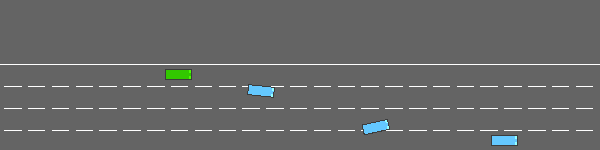

In [12]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display, Image
import imageio

# Collect frames
frames = []
obs, _ = env.reset()
for _ in range(30):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or truncated:
        obs, _ = env.reset()

# Create animation (but do NOT display it)
fig = plt.figure()
img = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    img.set_data(frames[i])
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100)

# IMPORTANT: Close the figure to prevent auto-display in notebook
plt.close(fig)

# Assign animation HTML but do NOT display it automatically
video_html = HTML(anim.to_html5_video())

# Save the frames as a GIF with infinite looping
imageio.mimsave('/tmp/highway_run.gif', frames, fps=10, loop=0)

# Show the saved GIF in notebook (this displays the GIF only and loops it)
display(Image(filename='/tmp/highway_run.gif'))



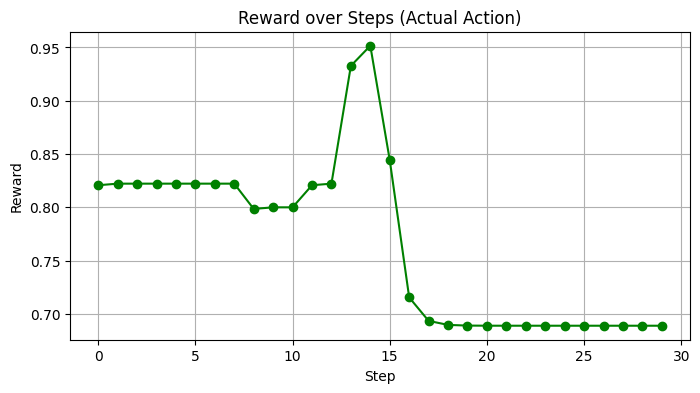

In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, Image
import imageio

# Collect frames and rewards
actual_frames = []
actual_rewards = []

obs, _ = env.reset()
for _ in range(30):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, _ = env.step(action)
    frame = env.render()

    actual_frames.append(frame)
    actual_rewards.append(reward)

    if done or truncated:
        obs, _ = env.reset()

# Plot actual action reward graph (optional here, or skip if you want only combined)
plt.figure(figsize=(8,4))
plt.plot(actual_rewards, marker='o', linestyle='-', color='green')
plt.title('Reward over Steps (Actual Action)')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()


-------------------------------------------------------------------------------***

# **Counterfactual Trajectory**


In [14]:
def simulate_trajectory(env, initial_obs, first_action, model=None, steps=10):
    env.reset()
    obs = initial_obs.copy()
    env.render()
    frames = []
    total_reward = 0

    obs, reward, done, truncated, _ = env.step(first_action)
    total_reward += reward
    frames.append(env.render())

    for _ in range(steps - 1):
        if done or truncated:
            break
        action, _ = model.predict(obs) if model else (env.action_space.sample(), None)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        frames.append(env.render())

    return frames, total_reward

In [15]:
obs, _ = env.reset()
actual_action, _ = model.predict(obs)
cf_action = (actual_action + 1) % env.action_space.n

actual_frames, actual_reward = simulate_trajectory(env, obs, actual_action, model)
cf_frames, cf_reward = simulate_trajectory(env, obs, cf_action, model)

/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


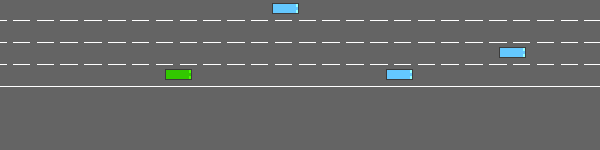

In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image, display
import imageio

# Step 1: Collect frames
frames = []
obs, _ = env.reset()
for _ in range(30):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or truncated:
        obs, _ = env.reset()

# Step 2: Create animation in memory (no static image shown)
fig = plt.figure()
img = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    img.set_data(frames[i])
    return [img]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100)
plt.close(fig)  # Prevents static image from displaying

# Optional: HTML5 video for inline playback
video_html = HTML(anim.to_html5_video())

# Step 3: Save as .gif with infinite loop
gif_path = "/tmp/highway_run.gif"
imageio.mimsave(gif_path, frames, fps=10, loop=0)  # <- loop=0 enables infinite looping

# Step 4: Display GIF only
with open(gif_path, "rb") as f:
    display(Image(data=f.read(), format='gif'))



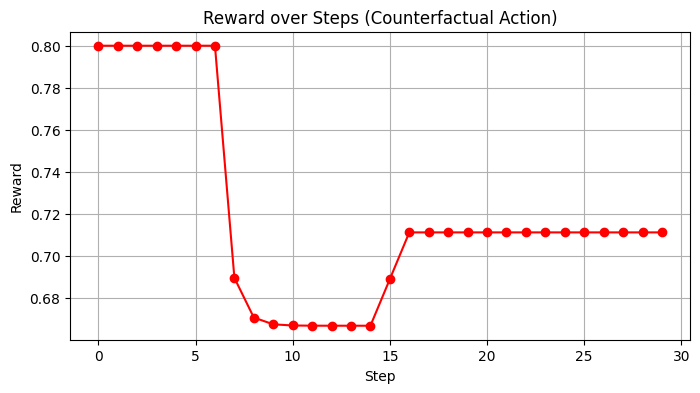

In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, Image
import imageio

# Collect frames and rewards
cf_frames = []
cf_rewards = []

obs, _ = env.reset()
for _ in range(30):
    action, _ = model.predict(obs)
    # Change action to counterfactual
    cf_action = (action + 1) % env.action_space.n
    obs, reward, done, truncated, _ = env.step(cf_action)

    frame = env.render()
    cf_frames.append(frame)
    cf_rewards.append(reward)

    if done or truncated:
        obs, _ = env.reset()

# Plot counterfactual reward graph (optional here, or skip if you want only combined)
plt.figure(figsize=(8,4))
plt.plot(cf_rewards, marker='o', linestyle='-', color='red')
plt.title('Reward over Steps (Counterfactual Action)')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()


# **Comparison**

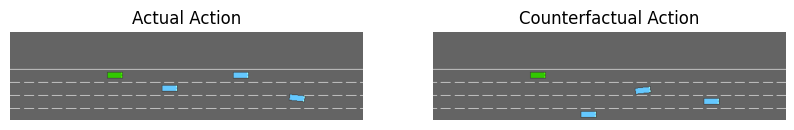

In [18]:
import matplotlib.pyplot as plt

def show_first_frame(actual_frames, cf_frames):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title("Actual Action")
    axs[1].set_title("Counterfactual Action")

    axs[0].imshow(actual_frames[0])
    axs[1].imshow(cf_frames[0])

    axs[0].axis('off')
    axs[1].axis('off')

    plt.show()

# Call this function to show the first frames side by side
show_first_frame(actual_frames, cf_frames)
